In [1]:
import torch
import sys

sys.path.insert(0, "../..")
from src.data import data_tools, make_dataset

Let's revisit the flowers dataset from the first lesson

In [20]:
data_dir = "../../data/raw"
image_folder = make_dataset.get_flowers(data_dir)
dataloader = data_tools.Dataloader(path=image_folder, split=0.8)


2022-05-24 10:52:31.990 | INFO     | src.data.make_dataset:get_flowers:73 - Data is downloaded to ../../data/raw/datasets/flower_photos.


We have 3670 images, in 5 classes

In [21]:
print(f"Numer of images: {len(dataloader)}")
print(f"classes: {dataloader.class_dict}")


Numer of images: 3670
classes: {'roses': 0, 'sunflowers': 1, 'daisy': 2, 'dandelion': 3, 'tulips': 4}


Because 3670 images is not that much for a model with millions of parameters, we will use some transforms

In [22]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine(10),
        transforms.ColorJitter(brightness=0.1, hue=0.1),
    ]
)


This will (at random) flip, scale, jitter an image. For the model, this is a new image, so it needs to focus on the general patterns instead of pixels.

In [23]:
config = {
    "batch_size": 32,
    "image_size": (224, 224),
    "channels": 3,
    "shuffle": True,
    "channel_first": True,
    "transforms": preprocess,
}

train_datastream = dataloader.data_generator(mode="train", **config)

test_datastream = dataloader.data_generator(mode="test", **config)


In [24]:
X, y = next(train_datastream)
X.shape, y.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

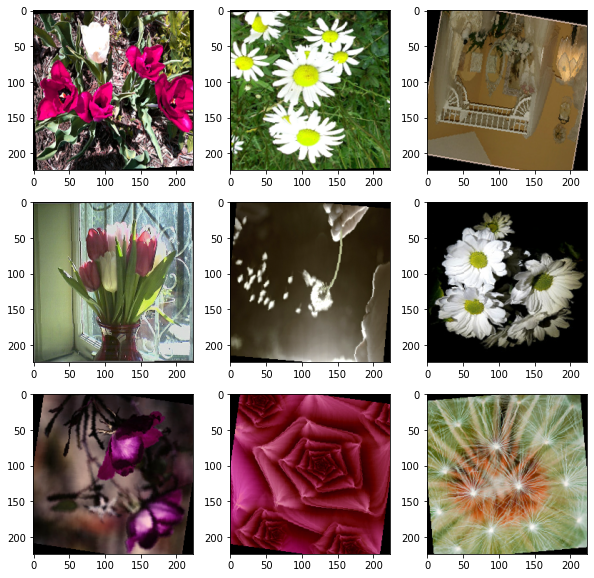

In [25]:
import matplotlib.pyplot as plt
img = X.permute(0, 2, 3, 1)
fig, axs = plt.subplots(3, 3, figsize=(10,10))
axs = axs.ravel()
for i in range(9):
    axs[i].imshow(img[i])

Let's check the ranges, mean and std of a batch

In [26]:
X.max(), X.min(), X.mean(), X.std()


(tensor(1.), tensor(0.), tensor(0.3602), tensor(0.2967))

Instead of building our own resnet, we will just download a pretrained version. This saves us many hours of training.

In [27]:
import torchvision
resnet = torchvision.models.resnet18(pretrained=True)


In [28]:
yhat = resnet(X)
yhat.shape


torch.Size([32, 1000])

However, the resnet is trained for 1000 classes. We have just 5...

We will swap the last layer and retrain the model.

First, we freeze all pretrained layers:

In [29]:
for name, param in resnet.named_parameters():
    param.requires_grad = False


If you study the resnet implementation on [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L206) you can see that the last layer is named `.fc`, like this:

```
 self.fc = nn.Linear(512 * block.expansion, num_classes)
 ```

This is a Linear layer, mapping from 512 * block.expansion to num_classes.


so we will swap that for our own. To do so we need to figure out how many features go into the .fc layer.
We can retrieve the incoming amount of features for the current `.fc` with `.in_features`

In [30]:
print(type(resnet.fc))
in_features = resnet.fc.in_features
in_features

512

Let's swap that layer with a small, two layer, neural network

In [31]:
import torch.nn as nn

resnet.fc = nn.Sequential(
    nn.Linear(in_features, 256), nn.ReLU(), nn.Dropout(0.1), nn.Linear(256, 5)
)


In [32]:
yhat = resnet(X)
yhat.shape


torch.Size([32, 5])

So, we have a fully trained resnet, but we added two layers at the end that transforms everything into 5 classes.
These layers are random, so we need to train them for some epochs

In [33]:
(len(dataloader) * 0.8) // 32


91.0

In [34]:
from src.models import metrics
accuracy = metrics.Accuracy()

This will take some time to train (about 4 min per epoch), you could scale down to amount of trainsteps to speed things up.

You will start with a fairly high learning rate (0.01), and if the learning stops, after patience epochs the learning rate gets halved.

In [35]:
from src.models import train_model

resnet = train_model.trainloop(
    epochs=10,
    model=resnet,
    metrics=[accuracy],
    optimizer=torch.optim.Adam,
    learning_rate=0.01,
    loss_fn=nn.CrossEntropyLoss(),
    train_dataloader=train_datastream,
    test_dataloader=test_datastream,
    log_dir="../../models/resnet",
    eval_steps=15,
    train_steps=25,
    patience=2,
    factor=0.5,
)


2022-05-24 10:52:41.088 | INFO     | src.data.data_tools:dir_add_timestamp:213 - Logging to ../../models/resnet/20220524-1052
100%|██████████| 25/25 [01:02<00:00,  2.49s/it]
2022-05-24 10:54:35.883 | INFO     | src.models.train_model:trainloop:171 - Epoch 0 train 1.9880 test 0.9828 metric ['0.6312']
100%|██████████| 25/25 [01:03<00:00,  2.55s/it]
2022-05-24 10:56:13.528 | INFO     | src.models.train_model:trainloop:171 - Epoch 1 train 0.8733 test 0.5618 metric ['0.7896']
100%|██████████| 25/25 [01:00<00:00,  2.40s/it]
2022-05-24 10:57:46.275 | INFO     | src.models.train_model:trainloop:171 - Epoch 2 train 0.6206 test 0.6403 metric ['0.7562']
100%|██████████| 25/25 [00:57<00:00,  2.31s/it]
2022-05-24 10:59:16.837 | INFO     | src.models.train_model:trainloop:171 - Epoch 3 train 0.6587 test 0.5753 metric ['0.7792']
 40%|████      | 4/10 [06:22<09:24, 94.07s/it]